Import necessary modules

In [1]:
import sys
sys.path.append("/net/server/homes/sep/ettore/research/packages/acoustic_isotropic_operators/test/lib/python/")
import genericIO
import SepVector
import Hypercube
import Acoustic_iso_double
import numpy as np
import time

Create wavelet and velocity model

In [2]:
!Wavelet n1=1001 d1=0.004 fund=10. tdelay=1. wavelet=ricker2 | Add scale=-1. > wlt.H

In [3]:
!Vel n1=560 d1=0.01 o1=0.0 n2=1904 d2=0.01 o2=0.0 n3=1 d3=0.01 o3=0.0 vc=2.0 | Pad beg1=5 end1=5 beg2=5 end2=5 > vel.H

Now lets start up genericIO read the files into memory

In [4]:
wavelet=genericIO.defaultIO.getVector("wlt.H")

In [5]:
velocity=genericIO.defaultIO.getVector("vel.H")

Lets make sure we've got got something reasonable


0.0


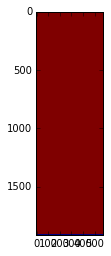

In [6]:
%matplotlib inline  
import matplotlib.pyplot as plt

print(velocity.getNdArray().min())
plt.imshow(velocity.getNdArray());

In [7]:
params={
"nts":1001,
"dts":0.004,
"sub":4,
"nz":570,
"nx":1914,
"zPadMinus":100,
"zPadPlus":110,
"xPadMinus":100,
"xPadPlus":104,
"dz":0.01,
"dx":0.01,
"fMax":16,
"zSource":10,
"xSource":850,
"nShot":1,
"spacingShots":1,
"depthReceiver":10,
"nReceiver":1700,
"dReceiver":1,
"oReceiver":1,
"saveWavefield":0,
"wavefieldShotNumber":0,
"blockSize":16,
"fat":5,
"nGpu":8}

Converting the velocity into double.

In [8]:
hyper=velocity.getHyper()
velDouble=SepVector.getSepVector(hyper,storage="dataDouble")
velDMat=velDouble.getNdArray()
velSMat=velocity.getNdArray()

for i2 in range(hyper.axes[1].n):
    for i1 in range(hyper.axes[0].n):
        velDMat[i2][i1]=velSMat[i2][i1]


Creating source vector

In [9]:
nzSource = 1;
ozSource =params["zSource"] - 1 + params["zPadMinus"] + params["fat"];
dzSource = 1;
nxSource = 1;
oxSource =params["xSource"] - 1 + params["xPadMinus"] + params["fat"];
dxSource = 1;
spacingShots = params["spacingShots"]
sourceVector=[]
for ishot in range(params["nShot"]):
    sourceVector.append(Acoustic_iso_double.deviceGpu(nzSource, ozSource, dzSource, nxSource, oxSource, dxSource, velDouble.getCpp(), params["nts"]))
    oxSource = oxSource + spacingShots;

Creating receiver vector

In [10]:
nzReceiver = 1;
ozReceiver = params["depthReceiver"] - 1 + params["zPadMinus"] + params["fat"];
dzReceiver = 1;
nxReceiver = params["nReceiver"]
oxReceiver = params["oReceiver"] - 1 + params["xPadMinus"] + params["fat"];
dxReceiver = params["dReceiver"];
                    
receiversVector=[]
nRecGeom = 1;# Constant receivers' geometry
for iRec in range(nRecGeom):
    receiversVector.append(Acoustic_iso_double.deviceGpu(nzReceiver, ozReceiver, dzReceiver, nxReceiver, oxReceiver, dxReceiver, velDouble.getCpp(), params["nts"]))


Convert the wavelet to double and convert it into 3DHyper

In [11]:
hyperTAxis=wavelet.getHyper().axes[0]
dumbAxis=Hypercube.axis(n=1)
modelHyper=Hypercube.hypercube(axes=[hyperTAxis,dumbAxis,dumbAxis])
waveletD=SepVector.getSepVector(modelHyper,storage="dataDouble")
waveDMat=waveletD.getNdArray()
waveSMat=wavelet.getNdArray()

for i1 in range(hyperTAxis.n):
    waveDMat[0][0][i1]=waveSMat[i1]

Now let's setup the data

In [12]:
receiverAxis=Hypercube.axis(n=nxReceiver, o=oxReceiver, d=dxReceiver)
sourceAxis=Hypercube.axis(n=params["nShot"], o=oxSource, d=dxSource)
dataD=SepVector.getSepVector(Hypercube.hypercube(axes=[hyperTAxis,receiverAxis,sourceAxis]),storage="dataDouble")
data=SepVector.getSepVector(Hypercube.hypercube(axes=[hyperTAxis,receiverAxis,sourceAxis]),storage="dataFloat")

We will use a dictionary for all the other parameters that might be needed.

In [13]:
paramP=genericIO.pythonParams(params)

Create simulation object

In [14]:
propagator=Acoustic_iso_double.nonlinearPropShotsGpu(waveletD,dataD,velDouble,paramP,sourceVector,receiversVector)

In [15]:
t0 = time.time()
propagator.forward(False, waveletD, dataD);
t1 = time.time()

total = t1-t0
print(total)

duration: 0.313226
3.918272018432617


Plotting data

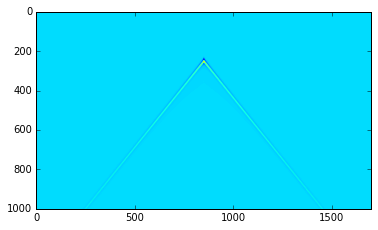

In [16]:
%matplotlib inline  
import matplotlib.pyplot as plt
data = np.reshape(dataD.getNdArray()[0,:,:],(1700,1001))
plt.imshow(data.T);

Dot-product test of propagator operator

In [17]:
propagator.dotTest(True)

Dot-product test of forward and adjoint operators
-------------------------------------------------
Applying forward operator add=False
duration: 0.307269
	Runs in: 0.6659801006317139 seconds
Applying adjoint operator add=False
	Runs in: 0.5840597152709961 seconds
Dot products add=False: domain=-0.00016822625057346334 range=-0.00016822625057346264 
Absolute error: 7.047314121155779e-19
Relative error: 4.189188130349663e-15 


Applying forward operator add=True
duration: 0.307099
	Runs in: 0.6363191604614258 seconds
Applying adjoint operator add=True
	Runs in: 0.596015453338623 seconds
Dot products add=True: domain=-0.000336452501146927 range=-0.0003364525011469251 
Absolute error: 1.8973538018496328e-18
Relative error: 5.639291713932241e-15 

-------------------------------------------------


Testing Born operator

In [18]:
#Converting the wavelet from a 3DReg to a list of 2DReg
hyperTAxis=wavelet.getHyper().axes[0]
dumbAxis=Hypercube.axis(n=1)
modelHyper=Hypercube.hypercube(axes=[hyperTAxis,dumbAxis])
waveletDBorn=SepVector.getSepVector(modelHyper,storage="dataDouble")
waveDBornNp=np.array(waveletDBorn.getCpp(),copy=False)
waveDNp=np.array(waveletD.getCpp(),copy=False)
waveDBornNp[0,:]=waveDNp[0,0,:]
waveletDBorn=[waveletDBorn]

born_op=Acoustic_iso_double.BornShotsGpu(velDouble,dataD,velDouble,paramP,sourceVector,waveletDBorn,receiversVector)

In [21]:
born_op.dotTest(True)

Dot-product test of forward and adjoint operators
-------------------------------------------------
Applying forward operator add=False
	Runs in: 1.5531418323516846 seconds
Applying adjoint operator add=False
	Runs in: 2.155806303024292 seconds
Dot products add=False: domain=-2.0344690749807844e-05 range=-2.0344690749808708e-05 
Absolute error: 8.639736061993863e-19
Relative error: 4.246678491328308e-14 


Applying forward operator add=True
	Runs in: 1.6527676582336426 seconds
Applying adjoint operator add=True
	Runs in: 2.073215961456299 seconds
Dot products add=True: domain=-4.068938149961616e-05 range=-4.0689381499617266e-05 
Absolute error: 1.1045309632196076e-18
Relative error: 2.7145435062216347e-14 

-------------------------------------------------
